# Classification With the Titanic Dataset

In this notebook you will practice a supervised learning problem with the titanic dataset. You will try to predict whether or not a particular passenger lived or died based on other data about that passenger such as age, sex, fare, etc. If you want to continue to explore this dataset, see the Titanic competition on Kaggle:

https://www.kaggle.com/c/titanic

## Imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load and prepare the data

In [2]:
raw_data = sns.load_dataset('titanic')

In [3]:
raw_data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.2+ KB


## 2. Cleaning data

Clean the raw data inplace by doing the following:

* Fill missing values in the age column with its mean.
* Convert bool columns to ints.
* Create a new int valued `child` column that is `1` when the `who` column is `child` and `0` otherwise.
* Drop the `alive`, `deck`, `embarked` and `adult_male` columns.

In [5]:
raw_data['age'].fillna(raw_data['age'].mean(), inplace=True)
raw_data['embark_town'].fillna('Unknown', inplace=True)
raw_data['alone'] = raw_data['alone'].astype(np.int)
raw_data['child'] = (raw_data['who'] == 'child').astype(np.int)
raw_data.drop(['alive', 'deck', 'embarked', 'adult_male'], axis=1, inplace=True)

Get the following tests to pass:

In [6]:
assert raw_data.pclass.isnull().value_counts()[False]==891
assert list(raw_data.sex.unique())==['male', 'female']
assert raw_data.age.isnull().value_counts()[False]==891
assert raw_data.sibsp.isnull().value_counts()[False]==891
assert raw_data.parch.isnull().value_counts()[False]==891
assert raw_data.fare.isnull().value_counts()[False]==891
assert list(raw_data['class'].unique())==['Third', 'First', 'Second']
towns = raw_data.embark_town.value_counts()
assert towns['Southampton']==644
assert towns['Cherbourg']==168
assert towns['Queenstown']==77
assert towns['Unknown']==2
a = raw_data.alone.value_counts()
assert a[0]==354
assert a[1]==537
cc = raw_data.child.value_counts()
assert cc[0]==808
assert cc[1]==83

assert list(raw_data.columns)==['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class',
       'who', 'embark_town', 'alone', 'child']

Here is a summary of the cleaned data:

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            891 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
class          891 non-null category
who            891 non-null object
embark_town    891 non-null object
alone          891 non-null int64
child          891 non-null int64
dtypes: category(1), float64(2), int64(6), object(3)
memory usage: 77.5+ KB


## 3. Features

Create a feature `DataFrame` named `X` with the numerical columns from the raw dataset:

In [8]:
numeric_features = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'child']
X = raw_data.loc[:, numeric_features]

In [9]:
assert list(X.columns)==['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'child']

Use `pandas.get_dummies` to one-hot-encode the `sex`, `class` and `embark_town` columns. Use the `drop_first` argument to drop one of the one-hot encoded columns for each of them. Ese `pandas.concat` to concat the new columns to `X`:

In [10]:
to_one_hot = ['sex', 'class', 'embark_town']
one_hot_df = pd.get_dummies(raw_data.loc[:, to_one_hot], columns=to_one_hot, drop_first=True, prefix='', prefix_sep='')
X = pd.concat([X, one_hot_df], axis=1)

In [11]:
X.head()

,pclass,age,sibsp,parch,fare,alone,child,male,Second,Third,Queenstown,Southampton,Unknown
0,3,22.0,1,0,7.2500,0,0,1,0,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0
3,1,35.0,1,0,53.1000,0,0,0,0,0,0,1,0
4,3,35.0,0,0,8.0500,1,0,1,0,1,0,1,0


In [12]:
assert list(X.columns)==['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'child', 'male',
       'Second', 'Third', 'Queenstown', 'Southampton', 'Unknown']

Here is the final features we will use:

In [13]:
X.head()

,pclass,age,sibsp,parch,fare,alone,child,male,Second,Third,Queenstown,Southampton,Unknown
0,3,22.0,1,0,7.2500,0,0,1,0,1,0,1,0
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1,0,1,0
3,1,35.0,1,0,53.1000,0,0,0,0,0,0,1,0
4,3,35.0,0,0,8.0500,1,0,1,0,1,0,1,0


## 4. Target

Create the target vector, `y`, from the `survived` column:

In [14]:
y = raw_data.survived

In [15]:
yc = y.value_counts()
assert yc[0]==549
assert yc[1]==342

## Train/test split

Use `sklearn.cross_validation.train_test_split` to split your data into a training and test set. Save the resulting data in the variables:

* `Xtrain`
* `Xtest`
* `ytrain`
* `ytest`

Do a train/test split, with 70% of the data used for training and a `random_state=0`:

In [16]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.70, random_state=0)

In [17]:
assert Xtrain.shape==(623,13)
assert ytrain.shape==(623,)
assert Xtest.shape==(268,13)
assert ytest.shape==(268,)

## Gaussian Naive-Bayes classifier

Perform the following steps with the `sklearn.naive_bayes.GaussianNB` classifier:

1. Instantiate the model class
2. Fit the model with the training data
3. Use the model to make predictions about the test data

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian_model = GaussianNB();
gaussian_model.fit(Xtrain, ytrain)
gaussian_ypredict = gaussian_model.predict(Xtest)

Compute the accuracy of the model:

In [19]:
print(accuracy_score(ytest, gaussian_ypredict))

0.742537313433


## Random forest classifier

Perform the following steps with the `sklearn.ensemble.RandomForestClassifier` classifier:

1. Instantiate the model class
2. Fit the model with the training data
3. Use the model to make predictions about the test data
4. Set `random_state=0`

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

rforest_model = RandomForestClassifier(max_depth=4, n_estimators=20, max_features='auto', random_state=0)
rforest_model.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Compute the accuracy of the model:

In [21]:
youtput = rforest_model.predict(Xtest)

print(accuracy_score(ytest, youtput))

0.817164179104


Use `cross_val_score` to perform k-fold cross validation (`k=10`) with this model:

In [22]:
val_scores = np.array(cross_val_score(rforest_model, X, y, cv=10))

Compute the average accuracy and its standard deviation:

In [23]:
print(val_scores.mean(), val_scores.std())

0.82386618999 0.0445362753371


Use `sklearn.metrics.confusion_matrix` and Seaborn's `heatmap` to display the confusion matrix for this model:

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


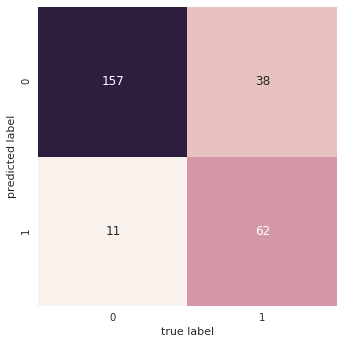

In [24]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, youtput)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Use the `feature_importances_` attribute of the model to create a `DataFrame` that has two columns:

1. `feature`: the names of the features
2. `importance`: the importances of that feature

Sort by the feature importances.

In [25]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rforest_model.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
7,male,0.431973
4,fare,0.164504
9,Third,0.131636
1,age,0.062489
0,pclass,0.055529
2,sibsp,0.037584
11,Southampton,0.031053
5,alone,0.024663
6,child,0.023570
3,parch,0.019166
